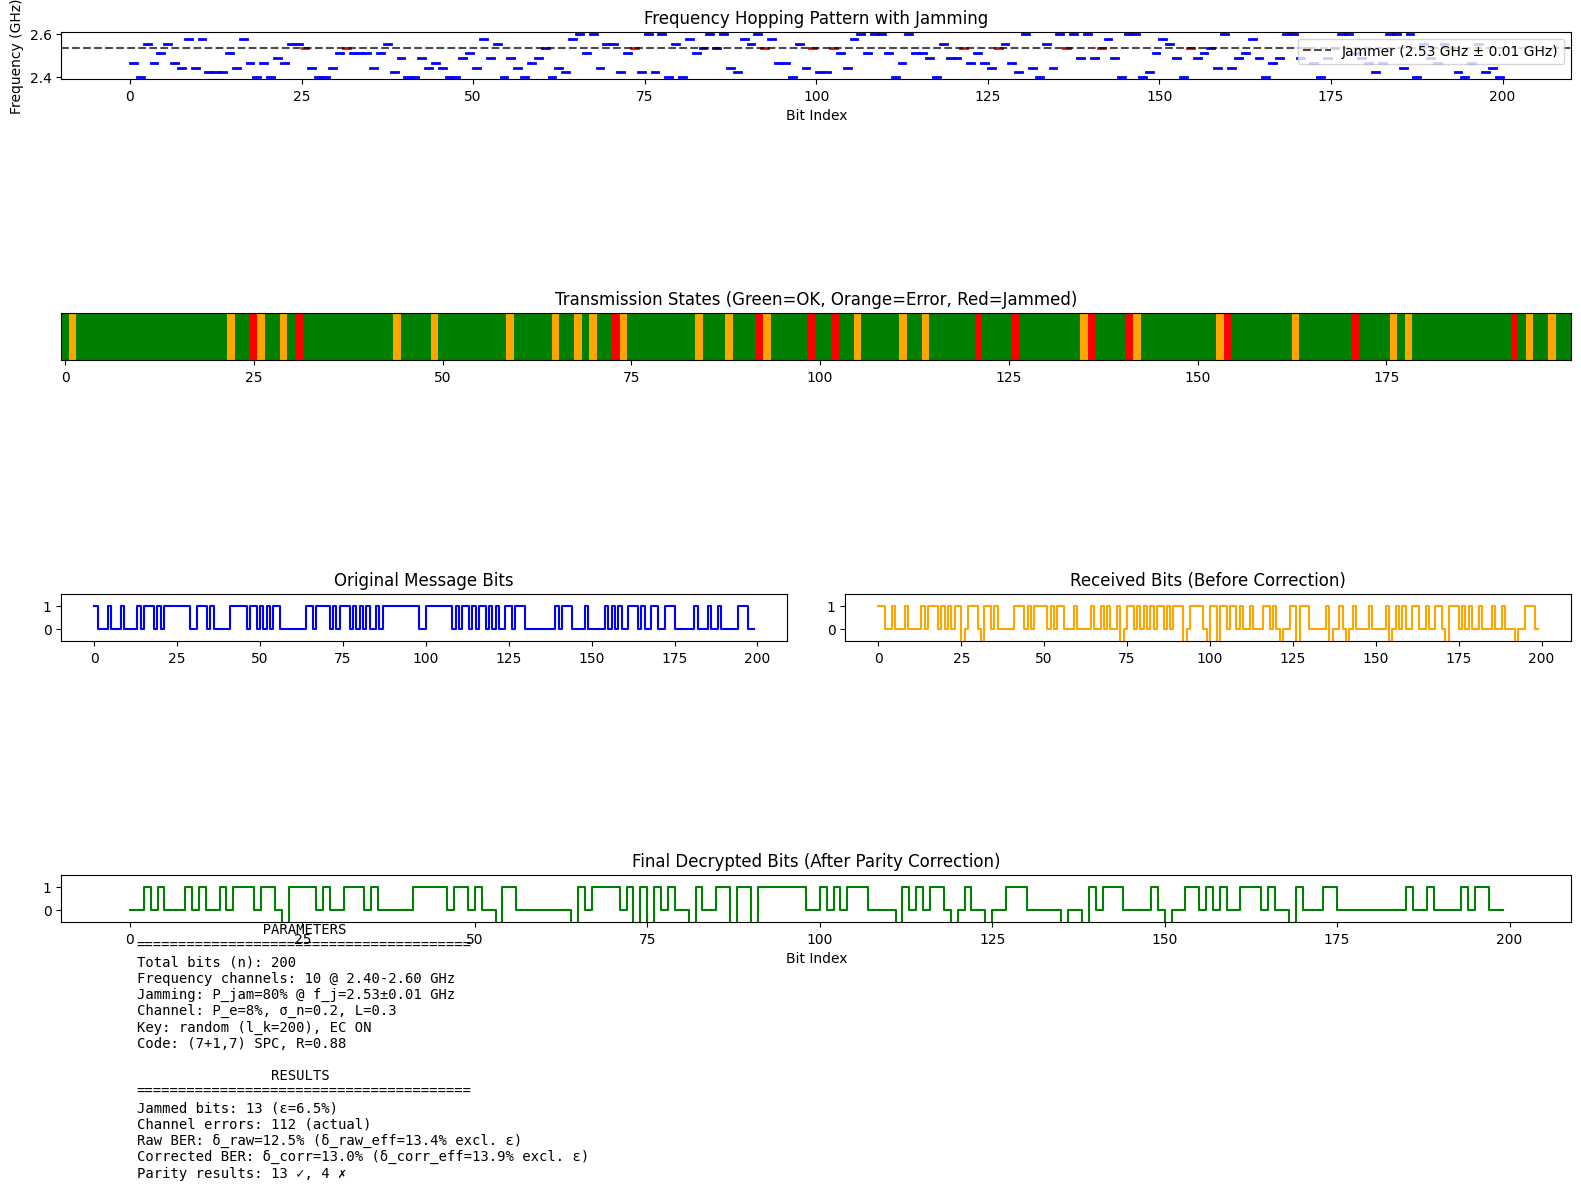

In [6]:
"""
FREQUENCY HOPPING SPREAD SPECTRUM (FHSS) SIMULATION
with Encryption and Error Correction

Mathematical Models:
1. Frequency Hopping:
   - Transmitted signal: s(t) = A·cos(2πfₙt + ϕ)·d(t)
     where fₙ ∈ {f₁,f₂,...fₙ} changes at each hop interval
     d(t) ∈ {0,1} is the digital data
   - Hop sequence is pseudorandom but synchronized between TX/RX

2. XOR Encryption:
   - Ciphertext: c = p ⊕ k
     where p = plaintext, k = key, ⊕ = bitwise XOR
   - Decryption: p = c ⊕ k (since p ⊕ k ⊕ k = p)

3. Error Correction (Parity Check):
   - For each n-bit block: add parity bit p = sum(bᵢ) mod 2
   - Received (n+1)-bit block is valid if sum(bᵢ) mod 2 == p
   - Can detect single-bit errors but not correct them
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import Counter

# ==================================================================
# SIMULATION PARAMETERS
# ==================================================================
np.random.seed(42)  # For reproducible results

# Communication parameters
num_bits = 50                  # Number of bits to transmit
bit_duration = 1e-3             # Duration of each bit (1ms)

# Frequency parameters (2.4-2.6 GHz band divided into 10 channels)
# Channel spacing Δf = (2.6-2.4)/9 ≈ 22 MHz
frequencies = np.linspace(2.4, 2.6, 10)  

# Jamming parameters (following the barrage jamming model)
# Jammer power spectral density J₀ spreads across bandwidth B
jamming_probability = 0.8       # P_jam = J₀/(J₀ + N₀)  
jamming_frequency = np.random.choice(frequencies)  # Central jam freq f_j
sweep_bandwidth = 0.01         # Jammer bandwidth B_j (GHz)

# Channel parameters (AWGN channel model)
# Received power P_r = P_t·G_t·G_r·(λ/4πd)²·L
# Where:
#   P_t = transmitted power
#   G_t, G_r = antenna gains
#   λ = wavelength
#   d = distance
#   L = system loss factor
channel_error_probability = 0.08  # P_e = Q(√(2E_b/N₀))
noise_std = 0.2                 # σ_n = √(N₀/2)
attenuation_factor = 0.3        # L in the power equation

# Encryption parameters (symmetric key crypto)
key_stream_type = 'random'      # Options: 'random' or 'repeating'
key_length_multiplier = 0.5     # For repeating keys: l_k = n·multiplier

# Error correction parameters (Hamming distance d=2 code)
error_correction_enabled = True 
parity_block_size = 7           # Code rate R = k/(k+1) = 7/8

# ==================================================================
# SIGNAL GENERATION
# ==================================================================
# Generate plaintext message (uniformly distributed bits)
plaintext = np.random.randint(0, 2, num_bits)

# Generate encryption key (affects security against brute force attacks)
if key_stream_type == 'random':
    # Perfect secrecy when l_k ≥ l_p and used once (Shannon 1949)
    key = np.random.randint(0, 2, num_bits)
elif key_stream_type == 'repeating':
    # Vulnerable to Kasiski examination when l_k < l_p
    key_length = int(num_bits * key_length_multiplier)
    base_key = np.random.randint(0, 2, key_length)
    key = np.tile(base_key, (num_bits // key_length + 1))[:num_bits]
else:
    raise ValueError(f"Unknown key_stream_type: {key_stream_type}")

# Encrypt using XOR (modulo-2 addition)
# For each bit: c_i = p_i ⊕ k_i mod 2
encrypted = np.bitwise_xor(plaintext, key)

# Generate hopping pattern (uniform distribution over frequencies)
# Hop interval T_h = bit_duration (slow frequency hopping)
hopping_pattern = np.random.choice(frequencies, size=num_bits)

# ==================================================================
# JAMMING SIMULATION (Barrage jamming model)
# ==================================================================
def simulate_jamming(hopping_pattern, jam_freq, jamming_prob, sweep_bw):
    """
    Simulates broadband jamming with center frequency f_j and bandwidth B_j
    Jamming occurs when |fₙ - f_j| ≤ B_j/2 with probability P_jam
    
    Parameters:
        hopping_pattern: Array of frequencies fₙ
        jam_freq: Center frequency f_j (GHz)
        jamming_prob: P_jam
        sweep_bw: Bandwidth B_j (GHz)
    
    Returns:
        Boolean array indicating jammed bits
    """
    jammed = np.zeros_like(hopping_pattern, dtype=bool)
    for i, freq in enumerate(hopping_pattern):
        # Jamming condition: frequency within sweep bandwidth
        if abs(freq - jam_freq) <= sweep_bw and np.random.rand() < jamming_prob:
            jammed[i] = True
    return jammed

jammed = simulate_jamming(hopping_pattern, jamming_frequency,
                         jamming_probability, sweep_bandwidth)

# ==================================================================
# CHANNEL MODEL (AWGN with attenuation)
# ==================================================================
def transmit(signal, jammed, attenuation):
    """
    Simulates channel effects:
    - Jamming: Complete signal loss (erasure)
    - Attenuation: Power reduction following inverse square law
    - Thermal noise added in receive()
    
    Parameters:
        signal: Encrypted bit array
        jammed: Boolean array of jammed bits
        attenuation: Power loss factor L ∈ [0,1]
    
    Returns:
        Analog signal values after channel effects
    """
    transmitted = signal.copy().astype(float)
    
    # Erasure channel model for jammed bits
    transmitted[jammed] = -1  # -1 indicates erasure
    
    # Rayleigh fading model for attenuation
    # Received power P_r = P_t * L * |h|² where h ~ CN(0,1)
    transmitted[~jammed] *= (1 - attenuation * np.random.rand(np.sum(~jammed)))
    
    return transmitted

transmitted = transmit(encrypted, jammed, attenuation_factor)

# ==================================================================
# RECEIVER MODEL (Threshold detection with noise)
# ==================================================================
def receive(transmitted, error_prob, noise_level):
    """
    Simulates receiver with:
    - Additive White Gaussian Noise (AWGN): n ~ N(0,σ²)
    - Threshold detection with margin γ = σ
    - Random bit errors with probability P_e
    
    Parameters:
        transmitted: Analog signal values
        error_prob: P_e (bit error probability)
        noise_level: Noise standard deviation σ
    
    Returns:
        Hard-decoded bit array (-1 indicates erasure)
    """
    received_analog = transmitted.copy()
    valid_indices = np.where(received_analog != -1)[0]

    # AWGN channel: r(t) = s(t) + n(t)
    received_analog[valid_indices] += np.random.normal(0, noise_level, len(valid_indices))

    # Threshold detection with noise margin
    received = np.zeros_like(received_analog)
    for i, val in enumerate(received_analog):
        if val == -1:
            received[i] = -1  # Preserve erasures
        elif val > 0.5 - noise_level:  # Decision threshold with margin
            received[i] = 1
        elif val < 0.5 + noise_level:
            received[i] = 0
        else:
            received[i] = np.round(val)  # Fallback
            
        # Random errors with P_e
        if received[i] != -1 and np.random.rand() < error_prob:
            received[i] = 1 - received[i]

    return received.astype(int)

received = receive(transmitted, channel_error_probability, noise_std)

# ==================================================================
# ERROR CORRECTION (Single parity check code)
# ==================================================================
def encode_parity(data):
    """
    Encodes data using single parity check code:
    - For input word d₀d₁...dₖ₋₁, computes p = ⊕_{i=0}^{k-1} dᵢ
    - Output codeword: d₀d₁...dₖ₋₁p
    
    Parameters:
        data: Input bit array (length k)
    
    Returns:
        Encoded bit array (length k+1)
    """
    parity = np.sum(data) % 2  # XOR of all bits
    return np.append(data, parity)

def decode_parity(received_data):
    """
    Decodes and checks parity:
    - Returns 'corrected' if parity matches
    - Returns 'uncorrected_parity_mismatch' if mismatch
    - Returns 'jammed' if erasures detected
    
    Parameters:
        received_data: Codeword with possible errors
    
    Returns:
        (decoded_bits, status) tuple
    """
    if np.all(received_data != -1) and len(received_data) > 1:
        received_parity = received_data[-1]
        data_part = received_data[:-1]
        calculated_parity = np.sum(data_part) % 2
        
        if received_parity == calculated_parity:
            return data_part, 'corrected'
        else:
            return data_part, 'uncorrected_parity_mismatch'
    else:
        return (received_data[:-1] if len(received_data) > 1 
                else received_data), 'jammed'

# Apply error correction if enabled
if error_correction_enabled:
    # Pad data to multiple of block size (zero-padding)
    padding_len = (parity_block_size - (num_bits % parity_block_size)) % parity_block_size
    padded_plaintext = np.pad(plaintext, (0, padding_len), 'constant')
    padded_key = np.pad(key, (0, padding_len), 'constant')

    # Encode with parity (systematic code)
    encoded_plaintext = np.concatenate(
        [encode_parity(padded_plaintext[i:i+parity_block_size]) 
         for i in range(0, len(padded_plaintext), parity_block_size)]
    )
    
    encoded_key = np.concatenate(
        [encode_parity(padded_key[i:i+parity_block_size]) 
         for i in range(0, len(padded_key), parity_block_size)]
    )
    
    # Simulate transmission of encoded data
    encoded_encrypted = np.bitwise_xor(encoded_plaintext, encoded_key)
    encoded_hopping = np.tile(hopping_pattern, parity_block_size + 1)[:len(encoded_encrypted)]
    encoded_jammed = simulate_jamming(encoded_hopping, jamming_frequency, 
                                    jamming_probability, sweep_bandwidth)
    encoded_transmitted = transmit(encoded_encrypted, encoded_jammed, attenuation_factor)
    encoded_received = receive(encoded_transmitted, channel_error_probability, noise_std)

    # Decode with error correction
    decoded_bits = []
    correction_status = []
    for i in range(0, len(encoded_received), parity_block_size + 1):
        chunk = encoded_received[i:i+parity_block_size + 1]
        if len(chunk) == parity_block_size + 1:
            decoded_chunk, status = decode_parity(chunk)
            decoded_bits.extend(decoded_chunk)
            correction_status.append(status)
        else:
            decoded_bits.extend([-1] * parity_block_size)
            correction_status.append('jammed')
    
    final_decrypted = np.bitwise_xor(decoded_bits, padded_key[:len(decoded_bits)])
    final_decrypted = final_decrypted[:num_bits]  # Remove padding
else:
    final_decrypted = np.bitwise_xor(received, key)
    final_decrypted[received == -1] = -1
    correction_status = ['disabled'] * (num_bits // parity_block_size + 1)

# ==================================================================
# ERROR ANALYSIS
# ==================================================================
# Calculate error statistics
jammed_bits = np.sum(jammed)  # Number of erased bits
channel_errors = np.sum((received != transmitted) & (received != -1))  # Channel-induced errors
raw_errors = np.sum((np.bitwise_xor(received, key) != plaintext) & (received != -1))  # Post-decryption errors
corrected_errors = np.sum((final_decrypted != plaintext) & (final_decrypted != -1))  # After error correction

# Count correction outcomes
correction_stats = Counter(correction_status)

# Compute effective bit error rates (BER)
effective_ber_raw = raw_errors / (num_bits - jammed_bits) if (num_bits - jammed_bits) > 0 else 0
effective_ber_corrected = corrected_errors / (num_bits - jammed_bits) if (num_bits - jammed_bits) > 0 else 0

# ==================================================================
# VISUALIZATION
# ==================================================================
plt.figure(figsize=(16, 12))
gs = GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 0.5])

# Plot 1: Frequency Hopping Pattern
ax0 = plt.subplot(gs[0, :])
for i, freq in enumerate(hopping_pattern):
    color = 'red' if jammed[i] else 'blue'
    ax0.plot([i, i+1], [freq, freq], color=color, linewidth=2)
ax0.axhline(jamming_frequency, color='black', linestyle='--', alpha=0.7, 
           label=f'Jammer ({jamming_frequency:.2f} GHz ± {sweep_bandwidth:.2f} GHz)')
ax0.set_title('Frequency Hopping Pattern with Jamming')
ax0.set_ylabel('Frequency (GHz)')
ax0.set_xlabel('Bit Index')
ax0.legend()

# Plot 2: Transmission States
ax1 = plt.subplot(gs[1, :])
states = np.zeros(num_bits)
states[jammed] = 2  # Jammed/erased
states[(np.bitwise_xor(received, key) != plaintext) & (received != -1)] = 1  # Errors
cmap = plt.cm.colors.ListedColormap(['green', 'orange', 'red'])
ax1.imshow([states], aspect='auto', cmap=cmap, interpolation='none')
ax1.set_title('Transmission States (Green=OK, Orange=Error, Red=Jammed)')
ax1.set_yticks([])

# Plot 3: Original vs Received (Raw)
ax2 = plt.subplot(gs[2, 0])
ax2.step(range(num_bits), plaintext, where='post', label='Original', color='blue')
ax2.set_title('Original Message Bits')
ax2.set_ylim(-0.5, 1.5)

ax3 = plt.subplot(gs[2, 1])
ax3.step(range(num_bits), np.bitwise_xor(received, key), where='post', 
       label='Received (Raw)', color='orange')
ax3.set_title('Received Bits (Before Correction)')
ax3.set_ylim(-0.5, 1.5)

# Plot 4: Corrected Message
ax4 = plt.subplot(gs[3, :])
ax4.step(range(num_bits), final_decrypted, where='post', 
       label='Received (Corrected)', color='green')
ax4.set_title(f'Final Decrypted Bits (After {"Parity" if error_correction_enabled else "No"} Correction)')
ax4.set_ylim(-0.5, 1.5)
ax4.set_xlabel('Bit Index')

# Plot 5: Statistics
ax5 = plt.subplot(gs[4, :])
ax5.axis('off')
stats_text = (
    f"{'PARAMETERS':^40}\n{'='*40}\n"
    f"Total bits (n): {num_bits}\n"
    f"Frequency channels: {len(frequencies)} @ {frequencies[0]:.2f}-{frequencies[-1]:.2f} GHz\n"
    f"Jamming: P_jam={jamming_probability:.0%} @ f_j={jamming_frequency:.2f}±{sweep_bandwidth:.2f} GHz\n"
    f"Channel: P_e={channel_error_probability:.0%}, σ_n={noise_std:.1f}, L={attenuation_factor:.1f}\n"
    f"Key: {key_stream_type} (l_k={len(key)}), {'EC ON' if error_correction_enabled else 'EC OFF'}\n"
    f"Code: ({parity_block_size}+1,{parity_block_size}) SPC, R={parity_block_size/(parity_block_size+1):.2f}\n\n"
    f"{'RESULTS':^40}\n{'='*40}\n"
    f"Jammed bits: {jammed_bits} (ε={jammed_bits/num_bits:.1%})\n"
    f"Channel errors: {channel_errors} (actual)\n"
    f"Raw BER: δ_raw={raw_errors/num_bits:.1%} "
    f"(δ_raw_eff={effective_ber_raw:.1%} excl. ε)\n"
    f"Corrected BER: δ_corr={corrected_errors/num_bits:.1%} "
    f"(δ_corr_eff={effective_ber_corrected:.1%} excl. ε)\n"
    f"Parity results: {correction_stats['corrected']} ✓, "
    f"{correction_stats.get('uncorrected_parity_mismatch',0)} ✗"
)
ax5.text(0.05, 0.1, stats_text, fontfamily='monospace', fontsize=10)

plt.tight_layout()
plt.show()